<h1> Twitter Sentiment Analysis: 2019 Canadian Federal Election <h1>

<h2> Link to Google Sheets <h2>

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from pprint import pprint # for better looking format when data is printed

from df2gspread import df2gspread as d2g # to export dataframes back to google sheets

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets','https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

In [3]:
creds = ServiceAccountCredentials.from_json_keyfile_name("Twitter-viz-data-fe1f7dd5839b.json", scope)
client = gspread.authorize(creds)

<h1> Data Collection <h1>

In [4]:
# Python libraries needed
import pandas as pd 
import numpy as np
import GetOldTweets3 as got # python library to scrape Twitter data

import os
os.chdir('C:/Users/Vijaya/Documents/Python Projects/Twitter')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

<h2> Scraping Twitter Data <h2>

In [5]:
def get_tweets(username, top_only, start_date, end_date, max_tweets):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                          .setTopTweets(top_only)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setMaxTweets(max_tweets)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    text_tweets = [[tw.date,
                tw.username,
                tw.text,           
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of tweets corresponding to tweet attributes
    tweets_df = pd.DataFrame(text_tweets, 
                            columns = ['Date', 'User', 'Text', 'Retweets', 'Favourites', 'Mentions', 'HashTags'])
    
    return tweets_df

In [6]:
# Defining the politicians twitter usernames that should be included
politician_sources = ['@JustinTrudeau', '@AndrewScheer', '@theJagmeetSingh', '@yfblanchet', '@ElizabethMay', '@MaximeBernier']

tweets_df = get_tweets(politician_sources, 
                     top_only = True,
                     start_date = "2019-09-11", 
                     end_date = "2019-10-21",
                    max_tweets = 500).sort_values('Date', ascending=False) # here the max number of tweets is being specifed and the tweet dates are sorted descending order.

In [7]:
# Tweets dataframe
tweets_df.head(10)

,Date,User,Text,Retweets,Favourites,Mentions,HashTags
0,2019-10-20 23:34:39+00:00,JustinTrudeau,"Andrew Scheer is against gay marriage, against...",3077,8977,,#ChooseForward
1,2019-10-20 23:34:13+00:00,theJagmeetSingh,Justin Trudeau could have built Pharmacare. In...,1104,10639,,#elxn43
20,2019-10-20 23:31:38+00:00,JustinTrudeau,For lower taxes for everyone except the 1%. #C...,279,1500,,#ChooseForward
2,2019-10-20 23:04:30+00:00,JustinTrudeau,The choice is clear. For a real plan to make l...,425,1248,,#ChooseForward
3,2019-10-20 22:54:05+00:00,MaximeBernier,I am so proud of our candidates. You showed in...,784,2501,,
21,2019-10-20 22:28:00+00:00,JustinTrudeau,For a serious plan to fight climate change. #C...,240,1278,,#ChooseForward
4,2019-10-20 21:57:46+00:00,JustinTrudeau,This new video says it all. Let’s keep going. ...,737,2206,,#ChooseForward
22,2019-10-20 21:51:07+00:00,JustinTrudeau,"For real, progressive policies that help Canad...",294,1128,,#ChooseForward
5,2019-10-20 21:42:30+00:00,theJagmeetSingh,"Tomorrow, Canadians get to choose an NDP gover...",541,3603,,#elxn43
6,2019-10-20 21:32:04+00:00,JustinTrudeau,Conservatives have nothing to offer Canadians ...,1937,6679,,#ChooseForward


<h2> Exporting dataframe as a CSV file <h2>

In [8]:
import tkinter as tk
from tkinter import filedialog

In [9]:
root= tk.Tk()

# Creates popup window
canvas1 = tk.Canvas(root, width = 300, height = 300, bg = 'black', relief = 'raised')
canvas1.pack()

# Creates function to export dataframe as CSV
def exportCSV ():
    global tweets_df
    
    export_file_path = filedialog.asksaveasfilename(defaultextension='.csv')
    tweets_df.to_csv (export_file_path, index = False, header=True)

saveAsButton_CSV = tk.Button(text='Export CSV', command=exportCSV, bg='white', fg='black', font='bold')
canvas1.create_window(150, 150, window=saveAsButton_CSV)

root.mainloop()

<h1> Exploratory Data Analysis <h1>

<h2> Data Manipulation <h2>

In [10]:
# Separates values in data column into individual columns
from datetime import datetime
date_format = "%Y-%m-%dT%H:%M:%S" 
tweets_df["hour"]   = pd.DatetimeIndex(tweets_df["Date"]).hour
tweets_df["month"]  = pd.DatetimeIndex(tweets_df["Date"]).month
tweets_df["day"]    = pd.DatetimeIndex(tweets_df["Date"]).day
tweets_df["month_f"]  = tweets_df["month"].map({9:"SEP",10:"OCT"})

#text manipulation
import re
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# Creates function to remove special characters, punctions, stop words, digits, hyperlinks and case conversion
def string_manipulation(df,column)  : 
    
    # convert to lower case
    df[column] = df[column].str.lower()
    # remove hyperlinks
    df[column] = df[column].apply(lambda x:re.split('https:\/\/.*',str(x))[0])
    # remove punctuations
    df[column] = df[column].str.replace('[^\w\s]'," ")
    # remove special characters
    df[column] = df[column].str.replace("\W"," ")
    # remove digits
    df[column] = df[column].str.replace("\d+"," ")
    # remove under scores
    df[column] = df[column].str.replace("_"," ")
    # remove stopwords
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_words)]))
    return df

In [11]:
tweets_df.head()

,Date,User,Text,Retweets,Favourites,Mentions,HashTags,hour,month,day,month_f
0,2019-10-20 23:34:39+00:00,JustinTrudeau,"Andrew Scheer is against gay marriage, against...",3077,8977,,#ChooseForward,23,10,20,OCT
1,2019-10-20 23:34:13+00:00,theJagmeetSingh,Justin Trudeau could have built Pharmacare. In...,1104,10639,,#elxn43,23,10,20,OCT
20,2019-10-20 23:31:38+00:00,JustinTrudeau,For lower taxes for everyone except the 1%. #C...,279,1500,,#ChooseForward,23,10,20,OCT
2,2019-10-20 23:04:30+00:00,JustinTrudeau,The choice is clear. For a real plan to make l...,425,1248,,#ChooseForward,23,10,20,OCT
3,2019-10-20 22:54:05+00:00,MaximeBernier,I am so proud of our candidates. You showed in...,784,2501,,,22,10,20,OCT


In [12]:
# Exports dataframe onto google sheets file
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'Master' # Creates new spreadsheet titled 'Master'
d2g.upload(tweets_df, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'Master' id:2010255824>

<h2> Tweets by Month <h2>

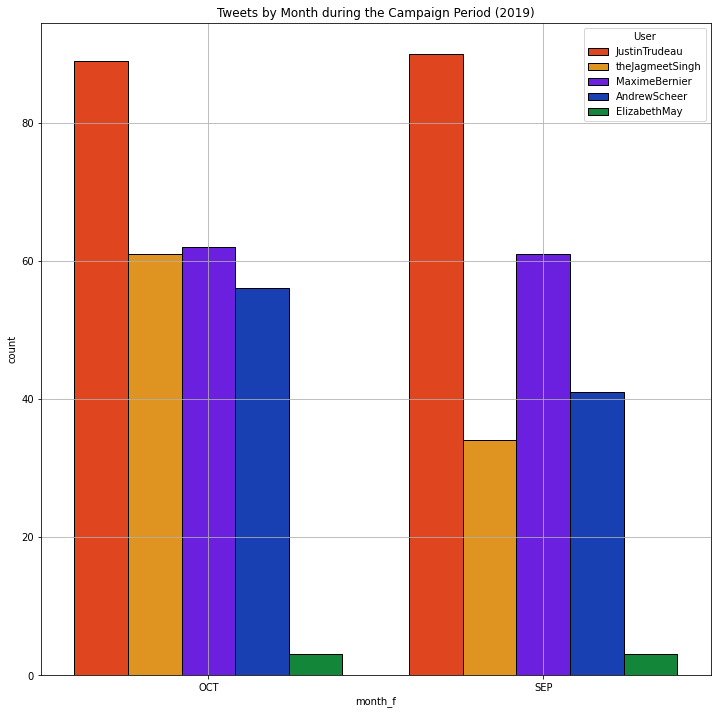

In [13]:
plt.figure(figsize = (12,12))
sns.countplot(x = tweets_df["month_f"], hue = tweets_df["User"], palette = ["#FF3300","#ff9900","#6600ff", "#0033cc", "#009933"], data = tweets_df.sort_values(by = "month"), linewidth = 1, edgecolor = "k"*tweets_df["month"].nunique())

plt.grid(True) # Displays gridlines on graph
plt.title("Tweets by Month during the Campaign Period (2019)") # Title of the graph
plt.show()

<h2> Scoring Tweets <h2>

In [14]:
positive_words_list = client.open("Twitter_Data").worksheet('Positive Words') # Indicates the worksheet name to be opened
negative_words_list = client.open("Twitter_Data").worksheet('Negative Words')

In [15]:
positive_words = positive_words_list.get_all_records()
negative_words = negative_words_list.get_all_records()

In [16]:
# Imports Google sheet as pandas dataframe; 0 indicates first row/column
positive_words = pd.DataFrame(positive_words[0:], columns=positive_words[0])
negative_words = pd.DataFrame(negative_words[0:], columns=negative_words[0])

In [17]:
# Assigns row as column headers
header_row = 1
positive_words.columns = positive_words.iloc[header_row]
negative_words.columns = negative_words.iloc[header_row]

In [18]:
# Drops header row
positive_words = positive_words.drop(header_row)
negative_words = negative_words.drop(header_row)

In [19]:
positive_words = positive_words.reset_index(drop=True)
negative_words = negative_words.reset_index(drop=True)

In [20]:
pprint(positive_words)

1         abound
0             a+
1        abounds
2      abundance
3       abundant
4     accessable
...          ...
2000    youthful
2001        zeal
2002      zenith
2003        zest
2004       zippy

[2005 rows x 1 columns]


In [21]:
# Positive words file
positive_words = pd.read_csv(r"positive-words.txt",
                             header=None)
# Negative words file
negative_words = pd.read_csv(r"negative-words.txt",
                             header=None)

In [22]:
# Convert words to lists
def convert_words_list(df) : 
    words = string_manipulation(df,0)
    words_list = words[words[0] != ""][0].tolist()
    return words_list

positive_words_list = convert_words_list(positive_words)
negative_words_list = convert_words_list(negative_words)

print ( "positive words : " )
print (positive_words_list[:50])
print ( "negative words : " )
print (negative_words_list[:50])

positive words : 
['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously']
negative words : 
['faced', 'faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent minded', 'absentee', 'absurd', 'absurdity', 'absurdly', 'absurdness', 'abuse', 'abused', 'abuses', 'abusive

scoring tweets based on positive and negative words count,

score = positive_count - negative_count

In [23]:
# function to score tweets based on positive and negative words present
def scoring_tweets(data_frame,text_column) :
    # identifying +ve and -ve words in tweets
    data_frame["positive"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split() 
                                                                              if i in (positive_words_list)]))
    data_frame["negative"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split()
                                                                              if i in (negative_words_list)]))
    # scoring
    data_frame["positive_count"] = data_frame["positive"].str.split().str.len()
    data_frame["negative_count"] = data_frame["negative"].str.split().str.len()
    data_frame["score"] = (data_frame["positive_count"] - data_frame["negative_count"])
    
    # create new feature sentiment :
    # +ve if score is +ve , #-ve if score is -ve , # neutral if score is 0
    def labeling(data_frame) :
        if data_frame["score"] > 0  :
            return "positive"
        elif data_frame["score"] < 0  :
            return "negative"
        elif data_frame["score"] == 0 :
            return "neutral"
    data_frame["sentiment"] = data_frame.apply(lambda data_frame:labeling(data_frame),
                                               axis = 1)
        
    return data_frame

tweets = scoring_tweets(tweets_df,"Text")

tweets[["Text","positive","negative","positive_count",
              "negative_count","score","sentiment"]].head()

,Text,positive,negative,positive_count,negative_count,score,sentiment
0,"Andrew Scheer is against gay marriage, against...",right stronger,,2,0,2,positive
1,Justin Trudeau could have built Pharmacare. In...,,,0,0,0,neutral
20,For lower taxes for everyone except the 1%. #C...,,,0,0,0,neutral
2,The choice is clear. For a real plan to make l...,affordable,,1,0,1,positive
3,I am so proud of our candidates. You showed in...,proud incredible courage passion better,negativity,5,1,4,positive


<h2> Scores distribution <h2> 

In [24]:
score_dist = tweets.groupby("User")["score"].value_counts().to_frame()
score_dist.columns = ["count"]
score_dist = score_dist.reset_index().sort_values(by = "score",ascending = False)

trace1 = go.Bar(x = score_dist[score_dist["User"] == "AndrewScheer"]["score"],
                y = score_dist[score_dist["User"] == "AndrewScheer"]["count"],
                marker = dict(line = dict(width = 1,color = "black"),
                             color = "#6666FF"),name = "Andrew Scheer"
              )

trace2 = go.Bar(x = score_dist[score_dist["User"] == "JustinTrudeau"]["score"],
               y = score_dist[score_dist["User"] == "JustinTrudeau"]["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "#FF3300"),name = "Justin Trudeau"
              )

layout = go.Layout(dict(title = "Scores distribution",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )
fig = go.Figure(data = [trace1,trace2],layout = layout)
py.iplot(fig)

<h2> CrossTab: Sentiment Distribution of Tweets <h2> 

In [25]:
# Crosstab
sent_dist = pd.crosstab(tweets["sentiment"],
                        tweets["User"]).apply(lambda r:
                                                r/r.sum()*100) # formula to calculate % for positive, neutral and negative tweets

sent_dist = sent_dist.reset_index()
t1 = go.Bar(x = sent_dist["sentiment"], y = sent_dist["AndrewScheer"],
            name = "Andrew Scheer",
            marker = dict(line = dict(width = 1, color = "#000000"), color = "#6666FF"))

t2 = go.Bar(x = sent_dist["sentiment"],y = sent_dist["JustinTrudeau"],
           name = "Justin Trudeau",
           marker = dict(line = dict(width = 1, color = "#000000"), color = "#FF3300"))

layout = go.Layout(dict(title = "Sentiment distribution",                                             
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2,title = "sentiment"),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2,title = "percentage"),
                        )
                  )
                  
fig = go.Figure(data = [t1,t2],layout = layout)
py.iplot(fig)

<h2> Popular Hashtags Used <h2> 

In [26]:
# Scheer tweets filtered into a separate dataframe
tweets_scheer  = (tweets[(tweets["User"] == "AndrewScheer")].reset_index()
                              .drop(columns = ["index"],axis = 1))
# Trudeau tweets filtered into a separate dataframe
tweets_trudeau  = (tweets[(tweets["User"] == "JustinTrudeau")].reset_index()
                              .drop(columns = ["index"],axis = 1))

In [43]:
# Singh tweets filtered into a separate dataframe
tweets_singh  = (tweets[(tweets["User"] == "theJagmeetSingh")].reset_index()
                              .drop(columns = ["index"],axis = 1))
# Bernier tweets filtered into a separate dataframe
tweets_bernier  = (tweets[(tweets["User"] == "MaximeBernier")].reset_index()
                              .drop(columns = ["index"],axis = 1))
# May tweets filtered into a separate dataframe
tweets_may  = (tweets[(tweets["User"] == "ElizabethMay")].reset_index()
                              .drop(columns = ["index"],axis = 1))

In [27]:
# Exports tweets_scheer dataframe onto google sheets file 
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'tweets_scheer' # Creates new spreadsheet 
d2g.upload(tweets_scheer, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'tweets_scheer' id:80906531>

In [28]:
# Exports tweets_trudeau dataframe onto google sheets file 
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'tweets_trudeau' # Creates new spreadsheet 
d2g.upload(tweets_trudeau, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'tweets_trudeau' id:1349516649>

In [44]:
# Exports tweets_singh dataframe onto google sheets file 
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'tweets_singh' # Creates new spreadsheet 
d2g.upload(tweets_singh, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'tweets_singh' id:1436770324>

In [45]:
# Exports tweets_bernier dataframe onto google sheets file 
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'tweets_bernier' # Creates new spreadsheet 
d2g.upload(tweets_bernier, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'tweets_bernier' id:487243528>

In [46]:
# Exports tweets_may dataframe onto google sheets file 
spreadsheet_key = '1vLUUPb1IZgZPUdHyrkNOUsMXup-XEnaDgvxr9Ze5P2o' # from spreadsheet URL
wks_name = 'tweets_may' # Creates new spreadsheet 
d2g.upload(tweets_may, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'tweets_may' id:946455895>

In [29]:
display(tweets_scheer.head(3).style.set_properties(**{}).set_caption("Scheer tweets"))
display(tweets_trudeau.head(3).style.set_properties(**{}).set_caption("Trudeau tweets"))

,Date,User,Text,Retweets,Favourites,Mentions,HashTags,hour,month,day,month_f,positive,negative,positive_count,negative_count,score,sentiment
0,2019-10-20 18:12:49+00:00,AndrewScheer,"Wow! Incredible energy as 2000 people packed the room in Richmond Hill last night! Tomorrow, millions of Canadians will be joining them and voting for our plan for them to get ahead!",397,1494,,,18,10,20,OCT,,,0,0,0,neutral
1,2019-10-20 17:57:13+00:00,AndrewScheer,"Five years ago this week, two Canadian heroes were murdered simply for wearing the uniform of the Canadian Armed Forces. This tragic anniversary reminds us that Canada is not immune to the threat of terrorism. (1/2)",570,1964,,,17,10,20,OCT,,tragic threat,0,2,-2,negative
2,2019-10-20 17:27:54+00:00,AndrewScheer,"The choice is clear: a Trudeau-NDP coalition you can’t afford or a Conservative majority which will put more money in your pockets. Less than 24 hours from Election Day, and I'm speaking about my plan to help you get ahead in Vancouver! TUNE IN:",514,1810,,,17,10,20,OCT,afford,,1,0,1,positive


,Date,User,Text,Retweets,Favourites,Mentions,HashTags,hour,month,day,month_f,positive,negative,positive_count,negative_count,score,sentiment
0,2019-10-20 23:34:39+00:00,JustinTrudeau,"Andrew Scheer is against gay marriage, against a woman's right to choose, against stronger gun control, and against fighting climate change. #ChooseForward",3077,8977,,#ChooseForward,23,10,20,OCT,right stronger,,2,0,2,positive
1,2019-10-20 23:31:38+00:00,JustinTrudeau,For lower taxes for everyone except the 1%. #ChooseForward,279,1500,,#ChooseForward,23,10,20,OCT,,,0,0,0,neutral
2,2019-10-20 23:04:30+00:00,JustinTrudeau,"The choice is clear. For a real plan to make life more affordable for Canadians, #ChooseForward. Vote Liberal.",425,1248,,#ChooseForward,23,10,20,OCT,affordable,,1,0,1,positive


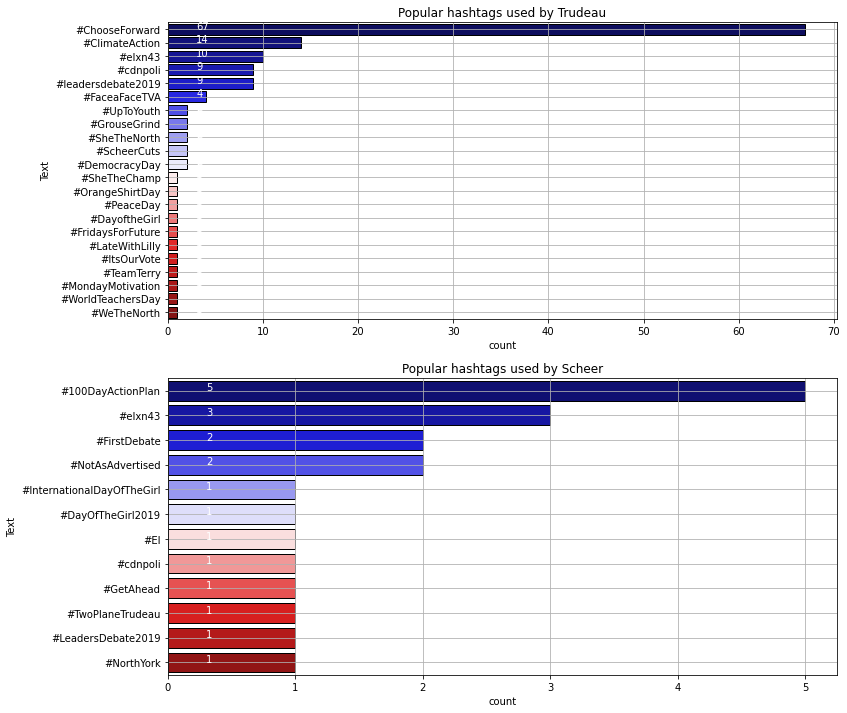

In [30]:
hashs_scheer = tweets_scheer["Text"].str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
hashs_scheer.columns = ["Text", "count"]

hashs_trudeau = tweets_trudeau["Text"].str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
hashs_trudeau.columns = ["Text", "count"]

plt.figure(figsize = (12,12))
plt.subplot(211)
ax = sns.barplot(x = "count" , y = "Text" ,
                 data = hashs_trudeau[:25] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k"* 25)
plt.grid(True)
for i,j in enumerate(hashs_trudeau["count"][:25].values) :
    ax.text(3,i,j, color = "white")
plt.title("Popular hashtags used by Trudeau")

plt.subplot(212)
ax1 = sns.barplot(x = "count" , y = "Text" ,
                 data = hashs_scheer[:25] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k"* 25)
plt.grid(True)
for i,j in enumerate(hashs_scheer["count"][:25].values) :
    ax1.text(.3,i,j, color = "white")
plt.title("Popular hashtags used by Scheer")

plt.show()

<h2> Favourite and Retweets by Sentiment <h2> 

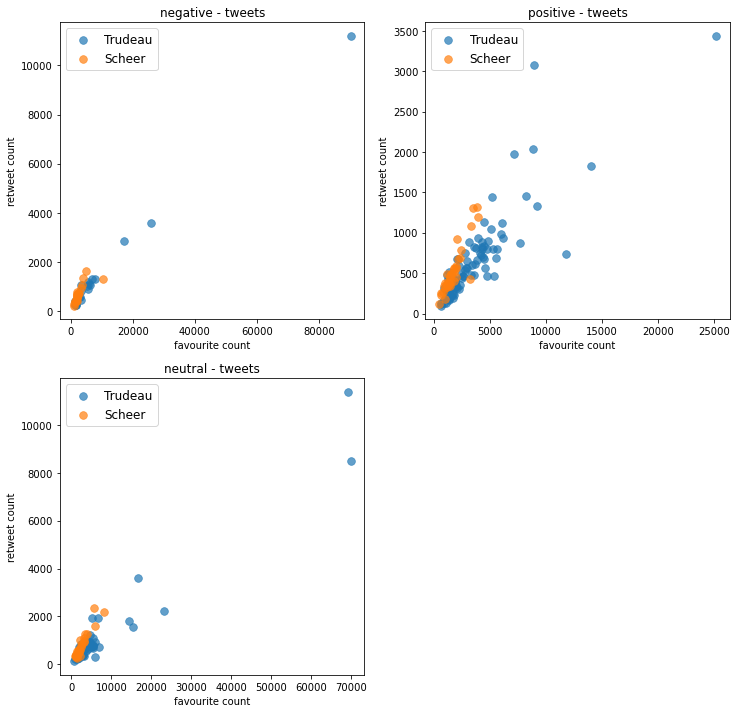

In [31]:
import itertools

lst =  ['negative', 'positive' ,'neutral']
cs  =  ["r","g","b"]

plt.figure(figsize = (12,12)) # size dimensions of the figure produced

for i,j,k in itertools.zip_longest(lst,range(len(lst)),cs) :
    plt.subplot(2,2,j+1)
    plt.scatter(x = tweets_trudeau[tweets_trudeau["sentiment"] == i]["Favourites"],
                y = tweets_trudeau[tweets_trudeau["sentiment"] == i]["Retweets"],
                label = "Trudeau", linewidth = .7, s = 60, alpha = .7)
    plt.scatter(x = tweets_scheer[tweets_scheer["sentiment"] == i]["Favourites"],
                y = tweets_scheer[tweets_scheer["sentiment"] == i]["Retweets"],
                label = "Scheer", linewidth = .7, s = 60, alpha = .7)

    plt.title(i + " - tweets")
    plt.legend(loc = "best",prop = {"size":12})
    plt.xlabel("favourite count")
    plt.ylabel("retweet count")

<h1> Classification using Random Forests <h1> 

<h2> Document Term matrix <h2>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to show individual tweets from each politician and the words that add up to their sentiment score
# Function also converts dataset into array for further data splicing
def return_dtm(df,column):
    
    documents = df[column].tolist()
    vectorizer = CountVectorizer()
    vec = vectorizer.fit_transform(documents)
    dtm = pd.DataFrame(vec.
    toarray(),columns = vectorizer.get_feature_names())
    dtm = df[[column,"sentiment"]].merge(dtm,left_index = True,
                                          right_index = True,how = "left")
    dtm["sentiment"] = dtm["sentiment"].map({"neutral" : 1,"positive" : 2, "negative" : 3})  
    
    return dtm

dtm_trudeau = return_dtm(tweets_trudeau,"Text")
dtm_scheer = return_dtm(tweets_scheer,"Text")
dtm_scheer = dtm_scheer.rename(columns = {"Text_x" : "Text"})


display(dtm_scheer.head(3).style.set_properties(**{}).set_caption("DTM - Scheer"))
display(dtm_trudeau.head(3).style.set_properties(**{}).set_caption("DTM - Trudeau"))

<h2> Building the Classification Model <h2>

In [33]:
# Data Splicing: the split is 70% training set and 30% testing set
from sklearn.model_selection import train_test_split

# Trudeau Tweets
predictors_trudeau = dtm_trudeau.drop(['sentiment', 'Text'], axis=1)
target_trudeau = dtm_trudeau['sentiment']

train_X_trudeau, test_X_trudeau, train_Y_trudeau, test_Y_trudeau = train_test_split(predictors_trudeau, target_trudeau, test_size=0.3, random_state=1)


# Scheer Tweets
predictors_scheer = dtm_scheer.drop(['sentiment', 'Text'], axis=1)
target_scheer = dtm_scheer['sentiment']

train_X_scheer, test_X_scheer, train_Y_scheer, test_Y_scheer = train_test_split(predictors_scheer, target_scheer, test_size=0.3, random_state=1)

In [34]:
# number of rows and columns in dataframe for Scheer
dtm_scheer.shape

(97, 872)

In [35]:
test_X_scheer.shape

(30, 870)

In [36]:
test_Y_scheer.shape

(30,)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import recall_score,precision_score,f1_score

# Creates function to run random forests algorithm on dataframes as requested
def classifier(train_X,test_X,train_Y,test_Y) :
    RF = RandomForestClassifier()
    RF.fit(train_X,train_Y)
    predictions = RF.predict(test_X)

    # Metrics to be outputed    
    print ("accuracy_score  : ",accuracy_score(predictions,test_Y))
    print ("recall_score    : ",recall_score(predictions,test_Y,average = "macro"))
    print ("precision_score : ",precision_score(predictions,test_Y,average = "macro"))
    print ("f1_score        : ",f1_score(predictions,test_Y,average = "macro"))

    # Confusion Matrix Visual
    plt.figure(figsize = (12,12))
    sns.heatmap(confusion_matrix(predictions,test_Y), annot = True,
                xticklabels= [ "neutral","positive","negative"],
                yticklabels= [ "neutral","positive","negative"],
                fmt = "d",linecolor = "w",linewidths = 2)
    plt.title("Confusion Matrix")
    plt.show()

<h2> Testing Model using Random Forests Classifer <h2>

accuracy_score  :  0.6
recall_score    :  0.5714285714285715
precision_score :  0.5168831168831168
f1_score        :  0.5200000000000001


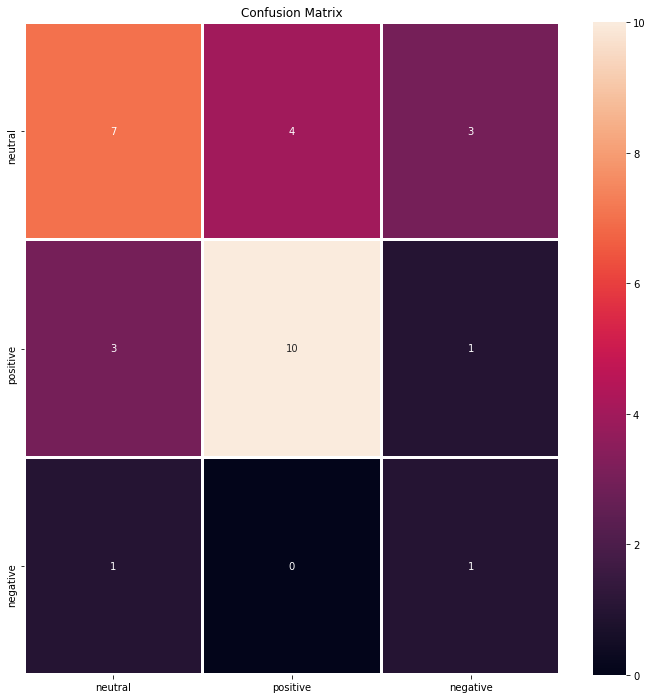

In [38]:
# classify Scheer tweets
classifier(train_X_scheer, test_X_scheer, train_Y_scheer, test_Y_scheer)

accuracy_score  :  0.5925925925925926
recall_score    :  0.37121212121212127
precision_score :  0.3925925925925926
f1_score        :  0.36229086229086227


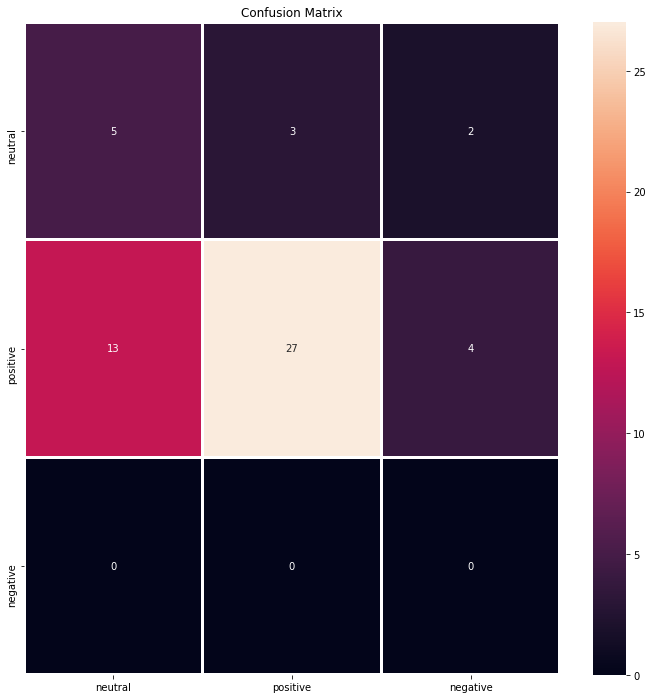

In [39]:
# classify Trudeau tweets
classifier(train_X_trudeau, test_X_trudeau, train_Y_trudeau, test_Y_trudeau)

<h1> Network Analysis of Tweets <h1>

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

# Function to create network analysis visuals
def network_tweets(df,frequency,color,title) :
    #documents
    documents  = df["Text"].tolist()
    vectorizer = CountVectorizer()
    vec        = vectorizer.fit_transform(documents)
    vec_t      = vectorizer.fit_transform(documents).transpose()
    
    #adjecency matrix for words
    adj_mat    = pd.DataFrame((vec_t * vec).toarray(),
                              columns = vectorizer.get_feature_names(),
                              index    = vectorizer.get_feature_names()
                             )
    # stacking combinations
    adj_mat_stack   = adj_mat.stack().reset_index()
    adj_mat_stack.columns = ["link_1","link_2","count"]
    
    # drop same word combinations
    adj_mat_stack   = adj_mat_stack[adj_mat_stack["link_1"] !=
                                    adj_mat_stack["link_2"]] 
    
    # subset dataframe with combination count greater than 25 times
    network_sub = adj_mat_stack[adj_mat_stack["count"] > frequency]
    
    #plot network
    H = nx.from_pandas_edgelist(network_sub,"link_1","link_2",["count"],
                                create_using = nx.DiGraph())

    ax = plt.figure(figsize = (12,12))
    nx.draw(H,with_labels = True,alpha = .7,node_shape = "H",
            width = 1,node_color = color,
            font_weight = "bold",style = "solid", arrowsize = 15 ,
            font_color = "white",linewidths = 10,edge_color = "grey",
            node_size = 1300,pos = nx.kamada_kawai_layout(H))
    plt.title(title,color = "white")
    ax.set_facecolor("k")  


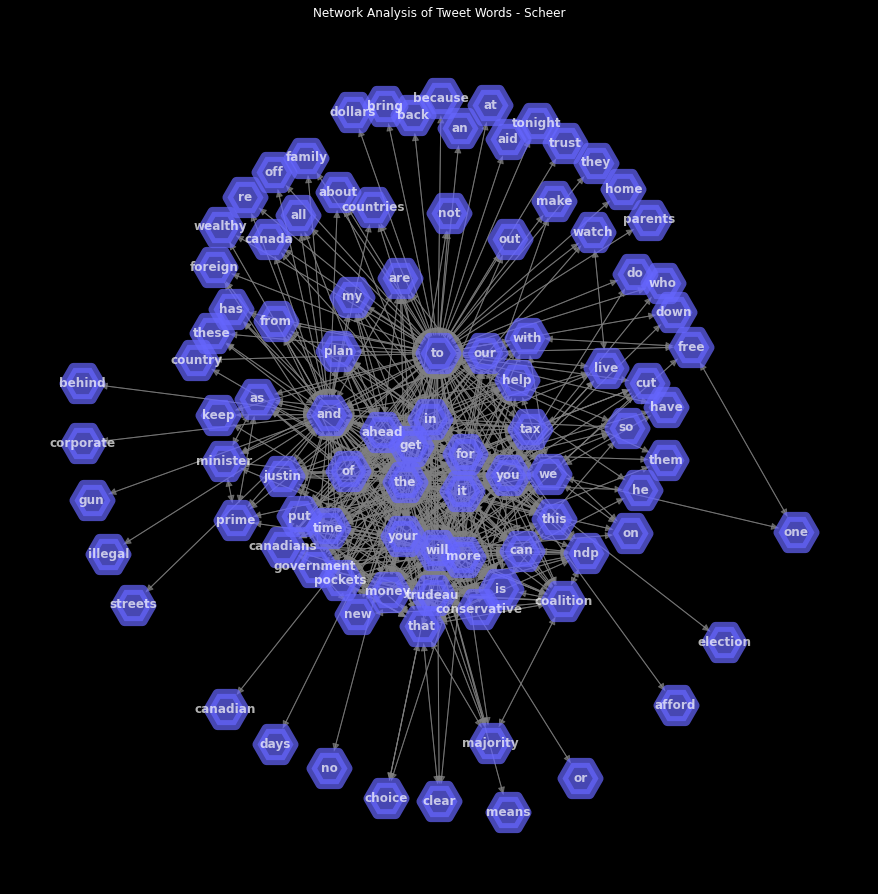

In [41]:
network_tweets(tweets_scheer,10,"#6666FF","Network Analysis of Tweet Words - Scheer")

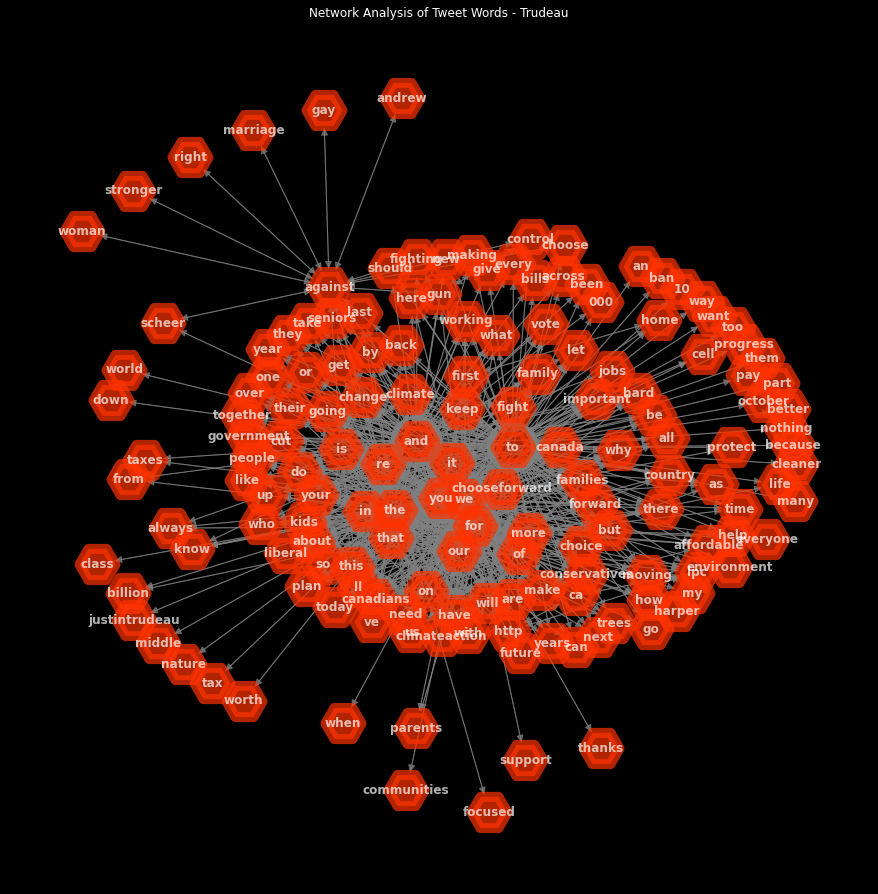

In [42]:
network_tweets(tweets_trudeau,10,"#FF3300","Network Analysis of Tweet Words - Trudeau")